In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# In this, we will ask "does an RNN do better than an autoregessive?"

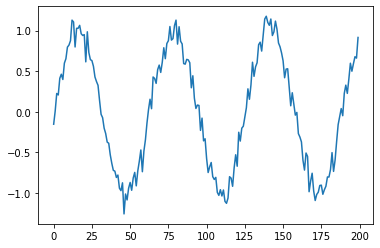

In [24]:
# Using synthetic data - a noisy sine wave (like in the autoregressive model)
series = np.sin(.1*np.arange(200)) + np.random.randn(200)*0.1

plt.plot(series)
plt.show()

In [25]:
# Build the dataset (supervised learning format)
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

# RNN expects a 3D input (NxTxD), so add a superfluous D=1 dimension to X
X = np.array(X).reshape(-1, T, D) # -1 is a wildcard, saying "do whatever, as long as the other dimensions are this"
Y = np.array(Y)
N = len(X)
print("X shape", X.shape, "Y shape", Y.shape)

X shape (190, 10, 1) Y shape (190,)


In [36]:
# Build the model (very similar to a simple ANN, just replace a Dense with a SimpleRNN)
i = Input(shape=(T, 1))
# Specify the hidden shape (5) i.e. hidden feature dimensionality
# Default activation is tanh for RNN
x = SimpleRNN(5, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1),
)
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 [==============================] - 1s 111ms/step - loss: 0.6890 - val_loss: 0.4156
Epoch 2/80
3/3 [==============================] - 0s 19ms/step - loss: 0.3559 - val_loss: 0.2187
Epoch 3/80
3/3 [==============================] - 0s 28ms/step - loss: 0.2483 - val_loss: 0.1262
Epoch 4/80
3/3 [==============================] - 0s 25ms/step - loss: 0.1422 - val_loss: 0.0746
Epoch 5/80
3/3 [==============================] - 0s 18ms/step - loss: 0.0755 - val_loss: 0.1011
Epoch 6/80
3/3 [==============================] - 0s 25ms/step - loss: 0.0559 - val_loss: 0.0355
Epoch 7/80
3/3 [==============================] - 0s 29ms/step - loss: 0.0390 - val_loss: 0.0258
Epoch 8/80
3/3 [==============================] - 0s 18ms/step - loss: 0.0296 - val_loss: 0.0366
Epoch 9/80
3/3 [==============================] - 0s 21ms/step - loss: 0.0271 - val_loss: 0.0244
Epoch 10/80
3/3 [==============================] - 0s 25ms/step - loss: 0.0265 - val_loss: 0.0233
Epoch 11/80
3/3 [======================

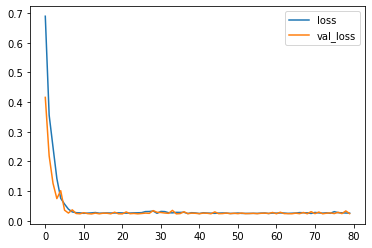

In [37]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [28]:
# Improper (one-step) forecasting
validation_target = Y[-N//2:] # 2nd half of Y
validation_predictions = []
# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  # Make predictions (pay attention to shapes). A single time-series is a 1D array of size T, so reshape to be 1xTx1
  # Output is NxK (K = 1 because scalar regression), so index at 0,0
  p = model.predict(X[i].reshape(1, -1, 1))[0,0]
  i += 1

  validation_predictions.append(p)

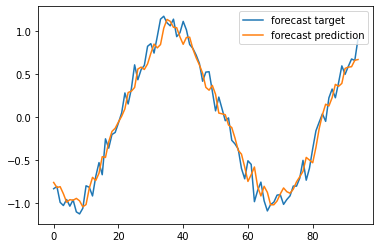

In [29]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [38]:
# Proper (multistep) forecasting
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1, 1))[0,0]
  
  validation_predictions.append(p)

  last_x = np.roll(last_x, -1)
  last_x[-1] = p 

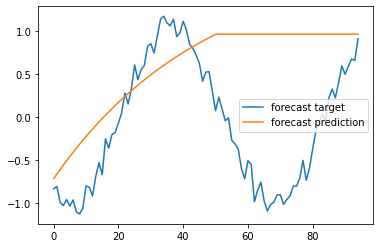

In [39]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
# With default parameters, RNN performs worse than the autoregressive model (which fit the dataset perfectly)
# The flexibility of an RNN, however, allows it to be more powerful things than an AR model.
# Using a tanh hidden activation, we get inconsistent results. Sometimes its better than linear model, other times its not
# So, more tuning may be required.
# Using relu activation, it uses the last value as the prediction. This isnt a good model, and wouldnt result in a sine wave for forecasting